<a href="https://colab.research.google.com/github/PGM-Lab/2023-ProbAI/blob/main/Day2-AfterLunch/notebooks/BayesianNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Neural Networks

Neural networks are powerful approximators. However, standard approaches for learning this approximators does not take into account the inherent uncertainty we may have when fitting a model.

In [1]:
!pip install -q pyro-ppl torch
import numpy as np
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Gamma, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

## Data

We use some fake data. As neural nets of even one hidden layer
can be universal function approximators, we can see if we can
train a simple neural network to fit a noisy sinusoidal data, like this:


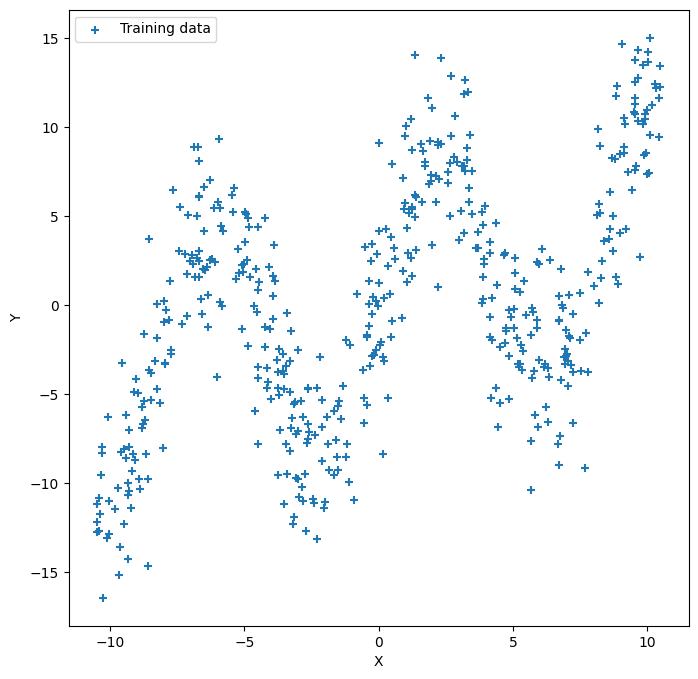

In [2]:

torch.manual_seed(999)
np.random.seed(999)

NSAMPLE = 500
x_train = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_train = np.float32(np.random.normal(size=(NSAMPLE,1),scale=3.0))
y_train = np.float32(np.sin(0.75*x_train)*7.0+x_train*0.5+r_train*1.0)

x_test = np.float32(np.arange(-20.5,20.5,0.1))
x_test = x_test.reshape(x_test.size,1)

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

x_test = torch.tensor(x_test)

plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

## Training a neural network

We employ a simple feedforward network with 20 hidden units to try to fit the data.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/MultiLayerPerceptron.png" alt="Drawing" width="450">
</center>





In [3]:
class NeuralNetwork():
    def __init__(self,NHIDDEN):
        self.w = torch.nn.Parameter(torch.randn(1, NHIDDEN)*0.05)
        self.b = torch.nn.Parameter(torch.randn(1, NHIDDEN)*0.05)
        self.w_out = torch.nn.Parameter(torch.randn(NHIDDEN,1)*0.05)
        self.b_out = torch.nn.Parameter(torch.randn(1, 1)*0.05)


    def params(self):
        return {"b":self.b, "w": self.w, "b_out":self.b_out, "w_out": self.w_out}

    def predict(self, x_data):
        hidden_layer = torch.nn.Tanh()(torch.mm(x_data, self.w) + self.b)
        return torch.matmul(hidden_layer,self.w_out) + self.b_out

NHIDDEN = 20
neuralNetwork = NeuralNetwork(NHIDDEN)

loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(neuralNetwork.params().values(), lr=0.01)
num_iterations = 1000

for j in range(num_iterations):
    # run the model forward on the data
    y_pred = neuralNetwork.predict(torch.tensor(x_train))
    # calculate the mse loss
    loss = loss_fn(y_pred, torch.tensor(y_train))
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    if (j + 1) % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

<ipython-input-3-ad1dffbdfc8d>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = neuralNetwork.predict(torch.tensor(x_train))
<ipython-input-3-ad1dffbdfc8d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(y_pred, torch.tensor(y_train))


[iteration 0100] loss: 16447.1836
[iteration 0200] loss: 14978.7324
[iteration 0300] loss: 12156.3711
[iteration 0400] loss: 7371.2280
[iteration 0500] loss: 5402.6284
[iteration 0600] loss: 4918.5688
[iteration 0700] loss: 4744.9800
[iteration 0800] loss: 4677.8506
[iteration 0900] loss: 4648.8569
[iteration 1000] loss: 4633.7725


We see that the neural network can fit this sinusoidal data quite well, as expected.

<ipython-input-8-8caea26bb775>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = neuralNetwork.predict(torch.tensor(x_test)).detach().numpy()


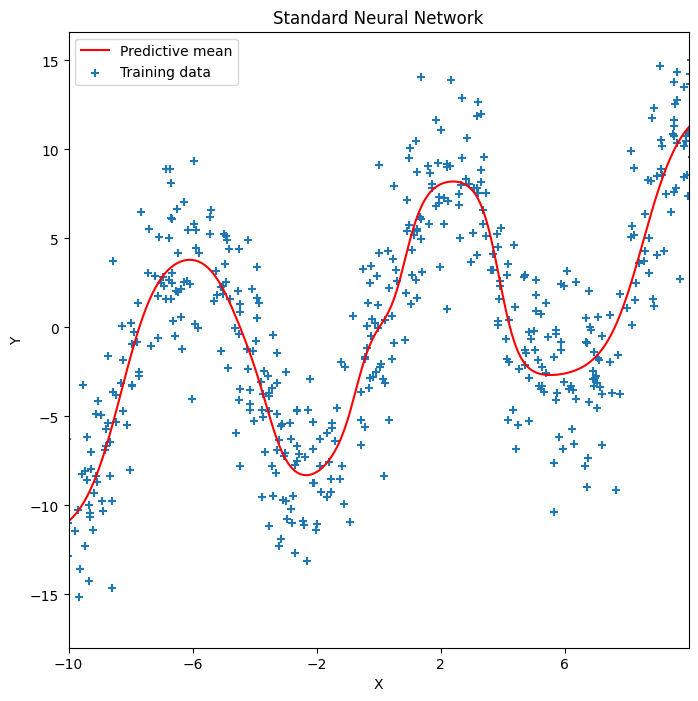

In [8]:

y_test = neuralNetwork.predict(torch.tensor(x_test)).detach().numpy()

plt.figure(figsize=(8, 8))
plt.plot(x_test, y_test, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.xlim(-10,10)
plt.xticks(np.arange(-10, 10, 4))
plt.title('Standard Neural Network')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();


However this model is unable to capture the uncertainty in the model. For example, when making predictions about a single point (e.g. around x=2.0) we can see we do not account aobut the inherent noise there is in this predictions. In next section, we will what happen when we introduce a Bayesian approach using

## Bayesian Learning of Neural Networks

[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a distribution over models that are consistent with the observed data.

In Bayesian learning, the weights of the network are `random variables`. The output of the nework is another `random variable`. And the random variable of the output is the one that implicitlyl defines the ``loss function``. So, when making Bayesian learning we do not define ``loss functions``, we do define ``random variables``.

In [5]:
def model(NHIDDEN, x_train, y_train):

  W = pyro.sample("W", Normal(loc = torch.zeros([1,NHIDDEN]), scale=1.).to_event())
  b = pyro.sample("b", Normal(loc = torch.zeros([1,NHIDDEN]), scale=1.).to_event())

  W_out = pyro.sample("W_out", Normal(loc = torch.zeros([NHIDDEN,1]), scale=1.).to_event())
  b_out = pyro.sample("b_out", Normal(loc = torch.zeros([1,1]), scale=1.).to_event())

  hidden_layer = torch.nn.Tanh()(torch.mm(x_train, W) + b)
  out =  torch.matmul(hidden_layer,W_out) + b_out
  predictive_mean = pyro.deterministic("predictive_mean", out)

  with pyro.plate("data", x_train.shape[0]):
    y = pyro.sample("y", Normal(loc = predictive_mean , scale= 1).to_event(1), obs=y_train)



In [6]:
from pyro.infer.autoguide import AutoNormal

# setup the optimizer
adam_args = {"lr": 0.01}
optimizer = Adam(adam_args)
guide = AutoNormal(model)

pyro.clear_param_store()

svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=10)
train_elbo = []
# training loop
for epoch in range(3000):
    loss = svi.step(NHIDDEN,x_train, y_train)
    train_elbo.append(-loss)
    if (epoch % 500) == 0:
        print("[epoch %03d] ELBO: %.4f" % (epoch, -loss))

/usr/local/lib/python3.10/dist-packages/pyro/infer/svi.py:57: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  warnings.warn(


[epoch 000] ELBO: -11212.6036
[epoch 500] ELBO: -8510.8060
[epoch 1000] ELBO: -4701.3461
[epoch 1500] ELBO: -3217.6495
[epoch 2000] ELBO: -3203.4924
[epoch 2500] ELBO: -3154.9539


As can be seen in the nex figure, the output of our model is not deterministic. So, we can caputure the uncertainty in the data. See for example what happens now with the predictions around the point `x=2.0`. See also what happens with the uncertainty in out-of-range predictions.

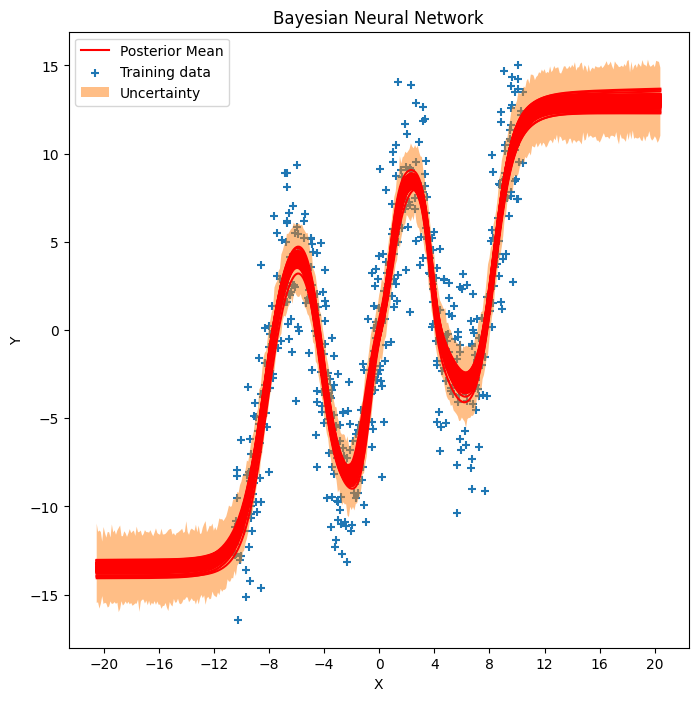

In [9]:

plt.figure(figsize=(8, 8))

predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100)
svi_samples = predictive(NHIDDEN, x_test, None)

y_predictive_mean = torch.squeeze(svi_samples['predictive_mean']).detach().numpy()

for i in range(y_predictive_mean.shape[0]):
      plt.plot(x_test,y_predictive_mean[i], color='red')

y_preds = torch.squeeze(svi_samples['y']).detach().numpy()

y_mean = np.mean(y_preds, axis=0)
y_sigma = np.std(y_preds, axis=0)

plt.plot(x_test, y_mean, 'r-', label='Posterior Mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma,
                 alpha=0.5, label='Uncertainty')

plt.xticks(np.arange(-20., 20.5, 4))
plt.title('Bayesian Neural Network')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

### <span style="color:red">Optional Exercise: </span>  Model the Variance

In the above model, the variance of the variable ``y`` was assumed fixed:

1. Introduce a Pyro parameter to learn the variance. Hint: Initialize with a very small value.

2. Introduce a Pryro random variable to learn the variance. Hint: Initialize the guide's random variable with a very small value.

3. Make the variance dependent of the input data

Evaluate the output in each cases and compare with the previous resutls.
